# Flickr8k Image Captioning

This notebook demonstrates a simplified supervised learning pipeline using the Flickr8k dataset with PyTorch. It is a demo version for assignment purposes

In [1]:

#DOWNLOAD THE FOLLOWING PACKAGES IF NOT ALREADY INSTALLED
%pip install pyttsx3
%pip install torchvision
%pip install torch
%pip install upgrade typing_extensions
%pip install gTTS
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Replace 'your_data_folder' with the actual path to your folder
data_path = "/Users/user/Desktop/Semester1/SE/archive"

## Data Collection
We assume you have the Flickr8k dataset downloaded:
- `Flickr8k_Dataset/` (images)
- `Flickr8k.token.txt` (captions)

We will load and prepare a subset for quick training.

In [3]:
import os
import pandas as pd
from PIL import Image

# Paths (adjust if needed)
images_path = "/Users/user/Desktop/Semester1/SE/archive/Images"
captions_file = "/Users/user/Desktop/Semester1/SE/archive/captions.txt"

# Load captions (comma-separated)
captions = pd.read_csv(captions_file, sep=',', names=['image','caption'], engine='python')

# Strip whitespace in image names
captions['image'] = captions['image'].str.strip()

captions.head()


,image,caption
0,image,caption
1,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...


## Data Exploration
- **Volume**: Number of images and captions
- **Velocity**: Static dataset (not streaming)
- **Variety**: Images + text
- **Veracity**: Some captions may be noisy

In [4]:
n_images = len(captions['image'].unique())
n_captions = len(captions)
print('Unique images:', n_images)
print('Total captions:', n_captions)


Unique images: 8092
Total captions: 40456


Cleaning Filenames to Avoid FileNotFound

In [5]:
# Clean filenames (remove whitespace, ensure lowercase)
captions['image'] = captions['image'].str.strip().str.lower()

# Map images to actual files in directory
available_files = {f.lower(): f for f in os.listdir(images_path)}

def map_file(img):
    return available_files.get(img, None)

captions['image'] = captions['image'].apply(map_file)

# Drop rows where the image wasn't found
captions = captions.dropna(subset=['image'])
print("Usable images:", captions['image'].nunique())


Usable images: 8091


## Preprocessing
- Transform images (resize, normalize)
- Tokenize captions
- Build vocabulary
- Split into train/dev/test

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from collections import Counter

# Subset for demo
# Reset index after groupby to ensure clean index for sampling
captions_subset = captions.groupby('image').head(1).reset_index(drop=True).sample(500, random_state=42).reset_index(drop=True)


# Image transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

# Tokenize captions
captions_subset['tokens'] = captions_subset['caption'].astype(str).apply(nltk.word_tokenize)

# Build vocab
all_tokens = [tok.lower() for tokens in captions_subset['tokens'] for tok in tokens]
vocab = {word:i+1 for i, (word,_) in enumerate(Counter(all_tokens).most_common(1000))}
vocab['<PAD>'] = 0

# Encode captions
def encode_caption(tokens, max_len=15):
    ids = [vocab.get(tok.lower(),0) for tok in tokens]
    ids = ids[:max_len] + [0]*(max_len-len(ids))
    return ids

captions_subset['encoded'] = captions_subset['tokens'].apply(lambda x: encode_caption(x))

# Split train/dev/test
train_df = captions_subset.sample(frac=0.7, random_state=42).reset_index(drop=True)
temp_df = captions_subset.drop(train_df.index).reset_index(drop=True)
dev_df = temp_df.sample(frac=0.5, random_state=42).reset_index(drop=True)
test_df = temp_df.drop(dev_df.index).reset_index(drop=True)

print("\nTrain DataFrame Head after splitting:")
print(train_df.head())

# Simple Dataset
class FlickrDataset(Dataset):
    def __init__(self, df, img_path, transform=None):
        self.df = df
        self.img_path = img_path
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(os.path.join(self.img_path, row['image'])).convert('RGB')
        if self.transform:
            img = self.transform(img)
        caption = torch.tensor(row['encoded'])
        return img, caption

# Suppose vocab is a dict: {word: idx}
inv_vocab = {idx: word for word, idx in vocab.items()}


train_data = FlickrDataset(train_df, images_path, transform)
dev_data = FlickrDataset(dev_df, images_path, transform)
test_data = FlickrDataset(test_df, images_path, transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=16)


Train DataFrame Head after splitting:
                       image  \
0  2921112724_5cb85d7413.jpg   
1  3225998968_ef786d86e0.jpg   
2  1456393634_74022d9056.jpg   
3  3474406285_01f3d24b71.jpg   
4  2847615962_c330bded6e.jpg   

                                             caption  \
0  A man riding a three wheeled vehicle topples o...   
1  A man on skis on a snow-covered hill with moun...   
2             A boy doing a handstand on the beach .   
3  a brown dog jumping over a blue and yellow sti...   
4            A dog lays on a mattress on the porch .   

                                              tokens  \
0  [A, man, riding, a, three, wheeled, vehicle, t...   
1  [A, man, on, skis, on, a, snow-covered, hill, ...   
2   [A, boy, doing, a, handstand, on, the, beach, .]   
3  [a, brown, dog, jumping, over, a, blue, and, y...   
4  [A, dog, lays, on, a, mattress, on, the, porch...   

                                             encoded  
0  [1, 10, 78, 1, 96, 426, 355, 873, 57

## Model
We use a pretrained ResNet as the encoder and an LSTM as the decoder. This is simplified for demo.

In [7]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images).squeeze()
        features = self.linear(features)
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens,_ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

embed_size = 128
hidden_size = 256
vocab_size = len(vocab)

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder, decoder = encoder.to(device), decoder.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0)
params = list(decoder.parameters()) + list(encoder.linear.parameters())
optimizer = optim.Adam(params, lr=0.001)

In [8]:
#testing algorithm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smooth = SmoothingFunction().method1

def evaluate_bleu(loader, n=5):
    encoder.eval(); decoder.eval()
    scores = []
    with torch.no_grad():
        for i, (imgs, caps) in enumerate(loader):
            if i >= n: break
            imgs, caps = imgs.to(device), caps.to(device)
            feats = encoder(imgs)
            outputs = decoder(feats, caps[:, :-1])
            preds = outputs.argmax(2).cpu().numpy()
            refs = caps.cpu().numpy()

            for r, p in zip(refs, preds):
                ref_caption = [inv_vocab.get(idx, '') for idx in r if idx not in [0,1,2]]
                hyp_caption = [inv_vocab.get(idx, '') for idx in p if idx not in [0,1,2]]
                ref_caption = [w for w in ref_caption if w]
                hyp_caption = [w for w in hyp_caption if w]

                if hyp_caption:
                    score = sentence_bleu([ref_caption], hyp_caption,
                                          smoothing_function=smooth, weights=(0.25,0.25,0.25,0.25))  # BLEU-1
                    scores.append(score)

    return sum(scores) / len(scores) if scores else 0


## Training & testing

Epoch 0, Loss: 4.8334, BLEU: 0.0000, Time: 20.07s
Epoch 1, Loss: 4.5258, BLEU: 0.0043, Time: 19.79s
Epoch 10, Loss: 4.5517, BLEU: 0.0137, Time: 19.56s
Epoch 20, Loss: 3.9177, BLEU: 0.0174, Time: 19.57s
Epoch 30, Loss: 3.6529, BLEU: 0.0226, Time: 19.54s
Epoch 40, Loss: 3.8143, BLEU: 0.0265, Time: 19.47s
Epoch 50, Loss: 3.5336, BLEU: 0.0304, Time: 19.97s
Epoch 60, Loss: 3.2550, BLEU: 0.0342, Time: 19.57s
Epoch 70, Loss: 3.2477, BLEU: 0.0392, Time: 19.58s
Epoch 80, Loss: 3.0365, BLEU: 0.0376, Time: 19.64s
Epoch 90, Loss: 3.0792, BLEU: 0.0457, Time: 19.40s
Epoch 100, Loss: 2.7288, BLEU: 0.0530, Time: 20.09s
Epoch 110, Loss: 2.5070, BLEU: 0.0593, Time: 19.36s
Epoch 120, Loss: 2.5691, BLEU: 0.0579, Time: 19.66s
Epoch 130, Loss: 2.2199, BLEU: 0.0595, Time: 19.58s
Epoch 140, Loss: 2.3740, BLEU: 0.0742, Time: 19.44s
Epoch 150, Loss: 1.9993, BLEU: 0.0907, Time: 19.49s
Epoch 160, Loss: 2.0652, BLEU: 0.1193, Time: 19.50s
Epoch 170, Loss: 1.8818, BLEU: 0.1452, Time: 19.44s
Epoch 180, Loss: 1.7779, 

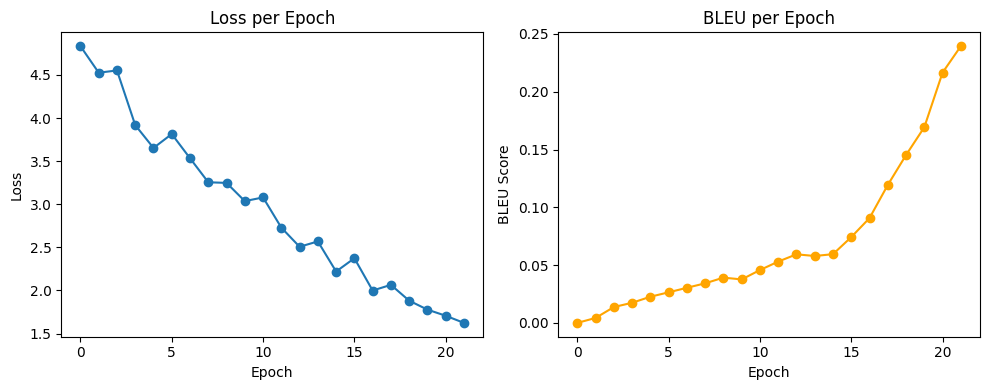

In [9]:
import matplotlib.pyplot as plt
import time

epoch_losses = []
epoch_bleus = []
epoch_times = []

for epoch in range(201):
    if epoch == 1 or epoch % 10 == 0 or epoch == 200:
        start_epoch = time.time()
        encoder.train(); decoder.train()
        for imgs, caps in train_loader:
            imgs, caps = imgs.to(device), caps.to(device)
            feats = encoder(imgs)
            outputs = decoder(feats, caps[:,:-1])
            loss = criterion(outputs.reshape(-1, vocab_size), caps.reshape(-1))
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        epoch_time = time.time() - start_epoch
        epoch_losses.append(loss.item())
        epoch_times.append(epoch_time)
        
        # Evaluate BLEU on dev set after each epoch
        bleu = evaluate_bleu(dev_loader)
        epoch_bleus.append(bleu)
        
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, BLEU: {bleu:.4f}, Time: {epoch_time:.2f}s')

print('Training time (s):', sum(epoch_times))
print('Losses per epoch:', epoch_losses)
print('BLEU per epoch:', epoch_bleus)

best_epoch = epoch_bleus.index(max(epoch_bleus))
print(f'Best epoch based on BLEU: {best_epoch} with BLEU: {max(epoch_bleus):.4f}')

# Plotting loss and BLEU score per epoch
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epoch_losses, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(epoch_bleus, marker='o', color='orange')
plt.title('BLEU per Epoch')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')

plt.tight_layout()
plt.show()

In [10]:
#training with best epoch number

import torch.optim as optim
import time

epoch_losses = []
epoch_bleus = []
epoch_times = []

for epoch in range(best_epoch):
    start_epoch = time.time()
    encoder.train(); decoder.train()
    for imgs, caps in train_loader:
        imgs, caps = imgs.to(device), caps.to(device)
        feats = encoder(imgs)
        outputs = decoder(feats, caps[:,:-1])
        loss = criterion(outputs.reshape(-1, vocab_size), caps.reshape(-1))
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    epoch_time = time.time() - start_epoch
    epoch_losses.append(loss.item())
    epoch_times.append(epoch_time)
    
    # Evaluate BLEU on dev set after each epoch
    bleu = evaluate_bleu(dev_loader)
    epoch_bleus.append(bleu)

print('Training time (s):', sum(epoch_times))
print('Losses per epoch:', epoch_losses)
print('BLEU per epoch:', epoch_bleus)

Training time (s): 405.3822410106659
Losses per epoch: [1.4736568927764893, 1.417759895324707, 1.2883589267730713, 1.3056793212890625, 1.220600962638855, 1.1154481172561646, 1.0638712644577026, 0.9946982860565186, 0.9647657871246338, 0.8584160208702087, 0.8547359108924866, 0.8364453315734863, 0.8079159259796143, 0.7421746253967285, 0.7474983334541321, 0.7142597436904907, 0.660817563533783, 0.6636509299278259, 0.6572880744934082, 0.5746613144874573, 0.6967605948448181]
BLEU per epoch: [0.25026688109197764, 0.290951278313491, 0.32202468854417804, 0.3511216114298529, 0.362960847057604, 0.3712125106552437, 0.39286557725554155, 0.40177070260802206, 0.4050667800900238, 0.41792321683153993, 0.41716458737231205, 0.415276111177467, 0.43194839293619014, 0.42772074061869225, 0.4234204450405203, 0.44543817703576016, 0.42994526498096985, 0.44210191976395985, 0.43496331464128996, 0.4439138480242976, 0.451287020732071]


In [11]:
# After training
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'loss': epoch_losses
}, "captioning_model.pth")

In [12]:
checkpoint = torch.load("captioning_model.pth", map_location=device)

encoder = EncoderCNN(embed_size)   # re-init your model
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=1)

encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

# Optional: restore optimizer & epoch
optimizer = optim.Adam(list(decoder.parameters()) + list(encoder.linear.parameters()))
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1


## change output to text

In [13]:
import numpy as np

# Suppose outputs is a tensor of shape [batch_size, seq_len, vocab_size]
batch_size = outputs.shape[0]

captions_text = []
for idx in range(batch_size):
    pred_indices = outputs[idx].argmax(dim=1).cpu().numpy()
    caption_words = [inv_vocab.get(j, '') for j in pred_indices if j != 0]
    caption_text = ' '.join(caption_words)
    captions_text.append(caption_text)
    print(f"Generated Caption {idx+1}:", caption_text)

# captions_text now contains all generated text descriptions, ready for gTTS

Generated Caption 1: a man girl is eating a peach . . . . . . . .
Generated Caption 2: a man of people is the street at night . . . . . .
Generated Caption 3: a brown dog in up some dust as he runs around a field . .
Generated Caption 4: a man in playing a boat while . . . . . . . .
Generated Caption 5: a man leaning on a dock by the water hugging . . . . .
Generated Caption 6: a man each sitting on a rock in front of a street . . .
Generated Caption 7: a man is riding along a white line in a busy city center . .
Generated Caption 8: a brown in basketball a pile of dead leaves . . . . . .
Generated Caption 9: a brown dog steps onto a log . . . . . . . .
Generated Caption 10: a man is sitting on and playing with smooth rocks . . . . .
Generated Caption 11: a man in near a fence . . . . . . . . .
Generated Caption 12: a man in a red kayak paddles as an orange kayak approaches from behind .
Generated Caption 13: a man wearing jumping a horizontal wooden structure with a in front of him .


In [14]:
test_loader = DataLoader(test_data, batch_size=16)
captions_text = []
encoder.eval(); decoder.eval()
with torch.no_grad():
    for imgs, caps in test_loader:
        imgs = imgs.to(device)
        feats = encoder(imgs)
        outputs = decoder(feats, caps[:,:-1].to(device))
        batch_size = outputs.shape[0]
        for idx in range(batch_size):
            pred_indices = outputs[idx].argmax(dim=1).cpu().numpy()
            caption_words = [inv_vocab.get(j, '') for j in pred_indices if j != 0]
            caption_text = ' '.join(caption_words)
            captions_text.append(caption_text)
            print(f"Generated Caption {len(captions_text)}:", caption_text)

# captions_text now contains all generated captions for the test set

Generated Caption 1: a man in sitting a a volleyball and . a . . . . .
Generated Caption 2: a man in a pink leotard is leaping through the air . . . .
Generated Caption 3: a man in a a large , with with on . . . . .
Generated Caption 4: a man girl in a swimsuit is in midair on a sunny day . .
Generated Caption 5: a man in playing a playing a dock subway the train with slide dog .
Generated Caption 6: a dogs are on a sidewalk of a sleek . arms orange . . .
Generated Caption 7: a man in a bounces on a bed bed . . . . . .
Generated Caption 8: a man is skis on a rail at night . . . . . .
Generated Caption 9: a man leaning over a concrete railing inside of a building . . . .
Generated Caption 10: a brown dog is a wooden . . . . . . . . .
Generated Caption 11: a man of people are standing in a red and and . . . .
Generated Caption 12: a man man jumping off a cliff into some water . . . . .
Generated Caption 13: a man makes through the air in front of a mountainous landscape . . .
Generated C

## Google text to speech

In [15]:
import json

# Load existing metrics from file
with open("training_metrics.json", "r") as f:
    metrics_data = json.load(f)

# Append new items
metrics_data["captions_text"] = captions_text[5]
metrics_data["epoch_losses"] = epoch_losses
metrics_data["epoch_bleus"] = epoch_bleus
metrics_data["total_training_time"] = total_training_time

# Save back to file
with open("training_metrics.json", "w") as f:
    json.dump(metrics_data, f)

FileNotFoundError: [Errno 2] No such file or directory: 'training_metrics.json'

## Evaluation
We evaluate with BLEU score on the dev set (demo only).

BLEU-4 for later with larger epochs

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def evaluate(loader, n=5):
    encoder.eval(); decoder.eval()
    scores = []
    with torch.no_grad():
        for i,(imgs,caps) in enumerate(loader):
            if i>=n: break
            imgs, caps = imgs.to(device), caps.to(device)
            feats = encoder(imgs)
            outputs = decoder(feats, caps[:,:-1])
            preds = outputs.argmax(2).cpu().numpy()
            refs = caps.cpu().numpy()
            for r,p in zip(refs,preds):
                scores.append(sentence_bleu([r.tolist()], p.tolist(), weights=(0.5,0.5)))
    return sum(scores)/len(scores)

bleu = evaluate(dev_loader)
print('Demo BLEU score:', bleu)

# Inference time 
You can compute the inference time by measuring how long it takes to generate captions for a batch of images using your trained model.

In [ ]:
import time

encoder.eval(); decoder.eval()
with torch.no_grad():
    imgs, caps = next(iter(dev_loader))  # Get one batch from dev set
    imgs = imgs.to(device)
    start_time = time.time()
    feats = encoder(imgs)
    outputs = decoder(feats, caps[:,:-1].to(device))
    inference_time = time.time() - start_time

print(f"Inference time for batch: {inference_time:.4f} seconds")

"""
This measures the time to run the encoder and decoder on one batch.
For per-image time, divide by batch size:
"""
print(f"Inference time per image: {inference_time / imgs.size(0):.4f} seconds")


## Inference time together with audio generation

In [ ]:
from gtts import gTTS
from IPython.display import Audio, display
import time

# Suppose captions_text contains all generated text descriptions
audio_generation_times = []

for i, caption in enumerate(captions_text):
    start_time = time.time()
    tts = gTTS(text=caption, lang='en')
    audio_file = f"caption_audio_{i+1}.mp3"
    tts.save(audio_file)
    audio_generation_time = time.time() - start_time
    audio_generation_times.append(audio_generation_time)
    print(f"Caption {i+1}: {caption} (Audio generation time: {audio_generation_time:.4f} seconds)")
    display(Audio(audio_file, autoplay=True))

# Example: print average audio generation time
print(f"Average audio generation time: {sum(audio_generation_times)/len(audio_generation_times):.4f} seconds")

## Intelligence Demo

In [ ]:
from gtts import gTTS
from IPython.display import Audio, display
import matplotlib.pyplot as plt

# Get a batch from the test loader
imgs, caps = next(iter(test_loader))
imgs = imgs.to(device)
encoder.eval(); decoder.eval()
captions_text = []
with torch.no_grad():
    feats = encoder(imgs)
    outputs = decoder(feats, caps[:,:-1].to(device))
    batch_size = outputs.shape[0]
    for idx in range(batch_size):
        pred_indices = outputs[idx].argmax(dim=1).cpu().numpy()
        caption_words = [inv_vocab.get(j, '') for j in pred_indices if j != 0]
        caption_text = ' '.join(caption_words)
        captions_text.append(caption_text)

# Display image, caption, and play audio for first 5 outputs
for i in range(min(5, batch_size)):
    img_np = imgs[i].cpu().permute(1,2,0).numpy()
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0, 1)
    plt.figure()
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"Caption: {captions_text[i]}")
    plt.show()
    tts = gTTS(text=captions_text[i], lang='en')
    audio_file = f"caption_audio_{i+1}.mp3"
    tts.save(audio_file)
    print(f"Caption {i+1}: {captions_text[i]}")
    display(Audio(audio_file, autoplay=True))